<a href="https://colab.research.google.com/github/pablo-arantes/EGB2025-MC14/blob/main/BioEmu_EGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

This is a Jupyter notebook for running Biomolecular Emulator (BioEmu for short), a model that samples from the approximated equilibrium distribution of structures for a protein monomer, given its amino acid sequence.
BioEmu outputs structures in backbone frame representation. To reconstruct the side-chains, several tools are available. As an example, we interface with HPacker (https://github.com/gvisani/hpacker) to conduct side-chain reconstruction.

BioEmu is based on the paper:

📄 Scalable emulation of protein equilibrium ensembles with generative deep learning

👨‍🔬 Authors: Sarah Lewis & Frank Noé (corresponding), et al.

📌 Read it here: https://www.biorxiv.org/content/10.1101/2024.12.05.626885v1.abstract

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to emulate of protein equilibrium ensembles with generative deep learning model in a cheap and yet feasible fashion.

---
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/making-it-rain/issues

**Acknowledgments**
- We would like to thank the [BioEmu](https://github.com/microsoft/bioemu) team for developing an excellent and open source model.

- A Making-it-rain by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- For related notebooks see: [Making-it-rain](https://github.com/pablo-arantes/making-it-rain)

# Introduction

In terms of inputs, we wil need:
*  An amino acid sequence of your protein.

In this notebook, we will emulate an equilibrium ensembles of a chignolin protein.







## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive.
2.   Copy the path of your created directory. We will use it below.

---
---
## Setting the environment for our calculations

Firstly, we need to install all necessary libraries and packages. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    BioEmu (https://github.com/microsoft/bioemu)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    AmberTools (https://ambermd.org/AmberTools.php)
8.    LogMD (https://github.com/log-md/logmd)

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import sys
import os
import subprocess
import shutil

commands = [
    "uv pip install --prerelease if-necessary-or-explicit bioemu==0.1.6",
    "pip install --upgrade MDAnalysis",
    "pip -q install py3Dmol",
    "mamba install -c conda-forge ambertools -y",
    "pip -q install logmd==0.1.30",

]

for cmd in commands:
    subprocess.run(cmd, shell=True)

# Path to the file
file_path = '/usr/local/lib/python3.11/pathlib.py'
backup_path = file_path + '.bak'

# Backup the original file
shutil.copyfile(file_path, backup_path)
print(f"Backup created at: {backup_path}")

# Read and modify the file
with open(file_path, 'r') as f:
    lines = f.readlines()

with open(file_path, 'w') as f:
    for line in lines:
        # Replace only exact matches
        if line.strip() == 'a = os.fspath(a)':
            indent = line[:len(line) - len(line.lstrip())]  # preserve indentation
            f.write(f"{indent}a = os.fspath(str(a))\n")
        else:
            f.write(line)

print("File updated successfully.")

Backup created at: /usr/local/lib/python3.11/pathlib.py.bak
File updated successfully.


In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul 10 19:21:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
#@title **Please, provide the necessary inputs**:

Google_Drive_Path = '/content/drive/MyDrive/BioEmu' #@param {type:"string"}
workDir = Google_Drive_Path
#@markdown - `sequence`: Monomer sequence to sample
Sequence = 'KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL' #@param {type:"string"}
#@markdown - `num_samples`: Number of samples requested
number_of_samples = 1000 #@param {type:"slider", min:10, max:5000, step:10}
#@markdown - `filter_samples`: Whether to filter unphysical samples (e.g., those containing chain breaks) from the written samples

filter_samples = True #@param {type:"boolean"}
#@markdown - `output`: Output folder name assigned to this job
output = 'lysozyme_EGB' #@param {type:"string"}

import os
from bioemu.sample import main as sample
sample(sequence=Sequence, num_samples=int(number_of_samples), output_dir=os.path.join(workDir, output), filter_samples=filter_samples)

/usr/local/lib/python3.11/site-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


checkpoints/bioemu-v1.0/checkpoint.ckpt:   0%|          | 0.00/125M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/580 [00:00<?, ?B/s]

Computing dlog_igso3_expansion: 100%|██████████| 1000/1000 [00:01<00:00, 845.51it/s]


In [ ]:
#@title **Concatenate and align the ensemble trajectory**
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import pytraj as pt

workDir = Google_Drive_Path
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]


workDir2 = os.path.join(workDir, output)
pdb_ref=  os.path.join(workDir2, "topology.pdb")
traj = os.path.join(workDir2, "samples.xtc")

nw_dcd = os.path.join(workDir2, "samples_fix." + str(Output_format))
nw_pdb = os.path.join(workDir2, "topology_fix.pdb")



u1 = mda.Universe(pdb_ref, traj)
u2 = mda.Universe(pdb_ref, pdb_ref)

u2.trajectory[0] # set u2 to first frame

align.AlignTraj(u1, u2, select='name CA', in_memory=True).run()

nw = u1.select_atoms("all")
with mda.Writer(nw_dcd, nw.n_atoms) as W:
  for ts in u1.trajectory[::int(Skip)]:
      W.write(nw, )
not_waters = u2.select_atoms("all")
not_waters.write(nw_pdb)
traj_dcd_check = os.path.exists(nw_dcd)
traj = nw_dcd
pdb_ref = nw_pdb


traj_load = pt.load(traj, pdb_ref)
print(traj_load)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

pytraj.Trajectory, 713 frames: 
Size: 0.010088 (GB)
<Topology: 633 atoms, 129 residues, 6 mols, PBC with box type = cubic>
           
Trajectory concatenated successfully! :-)


In [ ]:
#@title **Load, view and check the ensemble**
#@markdown This will take a few minutes.
import warnings
warnings.filterwarnings('ignore')
import py3Dmol
import MDAnalysis as mda
#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr


stride_animation =  100 #@param {type:"slider", min:0, max:1000, step:10}

workDir2 = os.path.join(workDir, output)
pdb_ref=  os.path.join(workDir2, "topology_fix.pdb")
traj = os.path.join(workDir2, "samples_fix." + str(Output_format))

u = mda.Universe(pdb_ref, traj)

# Write out frames for animation
protein = u.select_atoms('all')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title ### **View the Trajectory with RMSD and Rg analyisis Using LogMD**
#@markdown We will load the trajectory and analyze the Root Mean Square Deviation (RMSD) and Radius of Giration (Rg) using the powerful LogMD (https://github.com/log-md/logmd) library, which allows us to monitor the ensemble as it runs.

#@markdown **Once this cell finishes running, a link will appear — click on it to open and explore the full trajectory.**
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
from logmd import LogMD
from tqdm import tqdm
import numpy as np
import time

# Initialize LogMD
logmd = LogMD()

# Load the trajectory
workDir2 = os.path.join(workDir, output)
pdb_ref=  os.path.join(workDir2, "topology_fix.pdb")
traj = os.path.join(workDir2, "samples_fix." + str(Output_format))

u = mda.Universe(pdb_ref, traj)
# Align to the first frame (can also align to an average structure)
average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe

aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()

pdb_file = u.select_atoms("all")
pdb_file.write("topology.pdb")
u = mda.Universe("topology.pdb", traj)

# Store the initial positions for RMSD calculation
initial_position = u.select_atoms("name CA").positions

def fun(atoms):
    # Convert atoms to AtomGroup
    atom_group = u.select_atoms("name CA")

    # Calculate RMSD (no alignment)
    rmsd = np.sqrt(np.mean(np.sum((u.select_atoms("name CA").positions - initial_position) ** 2, axis=1)))

    # Calculate Radius of Gyration (Rg)
    com = atom_group.center_of_mass()
    rg = np.sqrt(np.mean(np.sum((u.select_atoms("name CA").positions - com) ** 2, axis=1)))

    # Data dictionary to log
    data_dict = {
        'rmsd': f"{rmsd:.2f} [A]",
        'rg': f"{rg:.2f} [A]",
    }

    return data_dict

# Run the analysis
a = LogMD.mdanalysis(u, fun, display_notebook=True)
# LogMD.display_notebook(a, width=1200, height=800)

[logmd] Load_time=0.97s 🚀

[logmd] Url=]8;id=812612;https://rcsb.ai/ed02eae049\https]8;;\]8;id=135428;https://rcsb.ai/ed02eae049\://rcsb.ai/ed02eae049]8;;\ 🚀

Processing frames: 100%|██████████| 713/713 [00:02<00:00, 257.01it/s]
Uploading: 100%|██████████| 10.3M/10.3M [00:02<00:00, 4.26MB/s]


[logmd] Url=]8;id=154864;https://rcsb.ai/cd9d707531\https]8;;\]8;id=888610;https://rcsb.ai/cd9d707531\://rcsb.ai/cd9d707531]8;;\ ✅

# **Calculating the Root Mean Square Fluctuation (RMSF) Over a Ensemble**

The root-mean-square-fluctuation (RMSF) of a structure is the time average of the RMSD. It is calculated according to the following equation, where $ x_i $ is the coordinates of particle $ i $, and $ \langle x_i \rangle $ is the ensemble average position of $ i $.

$ \rho_i = \sqrt{\left\langle (x_i - \langle x_i \rangle)^2 \right\rangle} $

Where the RMSD quantifies how much a structure diverges from a reference over time, the RMSF can reveal which areas of the system are the most mobile. While RMSD is frequently calculated to an initial state, the RMSF should be calculated to an average structure of the simulation. An area of the structure with high RMSF values frequently diverges from the average, indicating high mobility. When RMSF analysis is carried out on proteins, it is typically restricted to backbone or alpha-carbon atoms; these are more characteristic of conformational changes than the more flexible side-chains.


In [ ]:
#@title **Calculate RMSF of ensemble**

#@markdown ###**Select atoms for RMSF calculations:**
rmsf_sel = "protein and name CA" #@param {type:"string"}
#@markdown - First we calculate an average structure, then align each prediction to it and calculate the ensemble RMSF
#@markdown - Selection logic should follow [MDAnalysis syntax](https://docs.mdanalysis.org/stable/documentation_pages/selections.html)

import os
import glob
import re
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import seaborn as sns

import MDAnalysis as mda
from MDAnalysis.analysis import pca, align, rms

warnings.filterwarnings("ignore")

workDir2 = os.path.join(workDir, output)
pdb_ref=  os.path.join(workDir2, "topology_fix.pdb")
traj = os.path.join(workDir2, "samples_fix." + str(Output_format))

u = mda.Universe(pdb_ref, traj)

average = align.AverageStructure(u, u, select=rmsf_sel, ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select=rmsf_sel, in_memory=True).run()
c_alphas = u.select_atoms(rmsf_sel)
R = rms.RMSF(c_alphas).run()

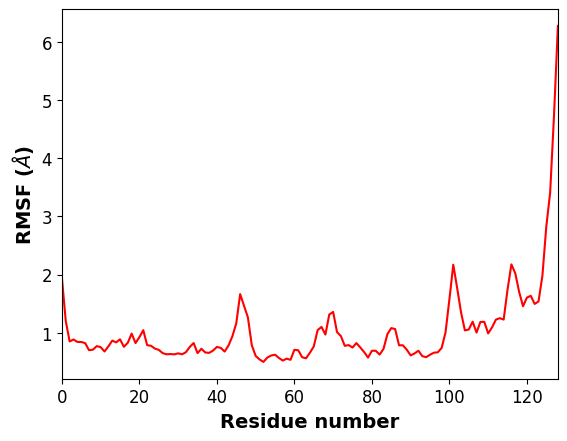

In [ ]:
#@title **Plot RMSFs**

# reorder = False # @param {type:"boolean"}
#new_first_index = "0" #@param {type:"string"}
import matplotlib.pyplot as plt
import pandas as pd

resid = c_alphas.resids
#@markdown ###**Residue (c-alpha) range to plot RMSF results:**
first_plotted_residue = min(c_alphas.resids)
last_plotted_residue = max(c_alphas.resids)
Output_name = 'rmsf_ca' #@param {type:"string"}

fig, ax = plt.subplots()
colors = ['blue', 'orange', 'green', 'purple', 'red', 'brown', 'magenta']
# Plotting on the passed axes object
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.plot(resid, R.results.rmsf, color='red')
ax.set_xlabel('Residue number', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('RMSF ($\AA$)', fontsize = 14, fontweight = 'bold')
ax.set_xlim(int(first_plotted_residue), int(last_plotted_residue))
plt.savefig(f'rmsf.png', dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(R.results.rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

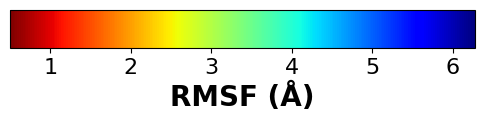

In [ ]:
#@title **Save the RMSF values as custom B factors and display the 3D structure**

import py3Dmol
import matplotlib as mpl

warnings.filterwarnings("ignore")

workDir2 = os.path.join(workDir, output)
pdb_ref=  os.path.join(workDir2, "topology_fix.pdb")
traj = os.path.join(workDir2, "samples_fix." + str(Output_format))

u = mda.Universe(pdb_ref, traj)

average = align.AverageStructure(u, u, select=rmsf_sel, ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select=rmsf_sel, in_memory=True).run()
c_alphas = u.select_atoms(rmsf_sel)
R = rms.RMSF(c_alphas).run()
rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue
rmsf_3d=[]
protein_write = u.select_atoms("protein")
protein_write.write("protein_bfactor.pdb")
u1=mda.Universe("protein_bfactor.pdb","protein_bfactor.pdb")
u1.add_TopologyAttr('tempfactors') #Initialization of B factors (tempfactors) by MDA in the Universe atoms
for atom in u1.atoms:
    rmsf_3d.append(rmsf_data.loc[atom.resid,'RMSF']) #A new list of RMSF must be created by ATOM. Our table has this values per aC. We can create a longer list easily
with mda.Writer(os.path.join(workDir, 'protein_rmsf.pdb'), u1) as PDB: #This is the functionality from MDA which allos us to save PDB files.
    for ts in u1.trajectory: #I'll save just the first frame in PDB as snapshot
        u1.atoms.tempfactors = rmsf_3d #This adds the custom B factors to the PDB snapshot
        PDB.write(u1.atoms)

def show_pdb(pdb_rmsf, R, analysis_range, color="RMSF"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_rmsf,'r').read(),'pdb')
  u=mda.Universe(pdb_rmsf,pdb_rmsf)
  c_alphas = u.select_atoms(analysis_range)
  rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue

  if color == "RMSF":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':min(rmsf_data['RMSF']),'max':max(rmsf_data['RMSF'])}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  view.zoomTo()
  return view

def bar_color(pdb_rmsf, R, analysis_range):
  u=mda.Universe(pdb_rmsf,pdb_rmsf)
  c_alphas = u.select_atoms(analysis_range)
  rmsf_data = pd.DataFrame(R.rmsf,index=c_alphas.resnums,columns=['RMSF'])
  fig, ax = plt.subplots(figsize=(6, 1))
  fig.subplots_adjust(bottom=0.5)

  cmap = mpl.cm.jet_r
  norm = mpl.colors.Normalize(vmin=min(rmsf_data['RMSF']), vmax=max(rmsf_data['RMSF']))

  cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='horizontal')
  cb1.set_label('RMSF (Å)',fontsize=20,fontweight='bold')
  cb1.ax.tick_params(labelsize=16)
  plt.show()
  return fig

rmsf_sel = "name CA"

show_pdb(os.path.join(workDir, 'protein_rmsf.pdb'), R, rmsf_sel, color="RMSF").show()
bar_color(os.path.join(workDir, 'protein_rmsf.pdb'), R, rmsf_sel).show()

---
# **Principal component analysis (PCA)**

Principal component analysis is a common linear dimensionality reduction technique that maps the coordinates in each frame of your trajectory to a linear combination of orthogonal vectors. The vectors are called principal components, and they are ordered such that the first principal component accounts for the most variance in the original data (i.e. the largest uncorrelated motion in your trajectory), and each successive component accounts for less and less variance. The frame-by-frame conformational fluctuation can be considered a linear combination of the essential dynamics yielded by the PCA. Please see http://www.springer.com/gp/book/9780387954424 and https://doi.org/10.1063/1.4885338, for a more in-depth introduction to PCA.

In [ ]:
#@title **Calculating the Principal component analysis (PCA)**
import warnings
warnings.filterwarnings('ignore')

#@markdown **Provide inputs below:**
Selection1 = '120' #@param {type:"string"}
Selection2 = '130' #@param {type:"string"}

import MDAnalysis as mda
import MDAnalysis.analysis.pca as pca

u = mda.Universe(pdb_ref,traj)
pca_calc = pca.PCA(u, select=f'resid {Selection1}:{Selection2}')
pca_calc.run()

Cumulated variance for PC1: 0.390
Cumulated variance for PC2: 0.589
Cumulated variance for PC3: 0.697
Cumulated variance for PC4: 0.760
Cumulated variance for PC5: 0.804
Cumulated variance for PC6: 0.840
Cumulated variance for PC7: 0.870
Cumulated variance for PC8: 0.888
Cumulated variance for PC9: 0.903
Cumulated variance for PC10: 0.915


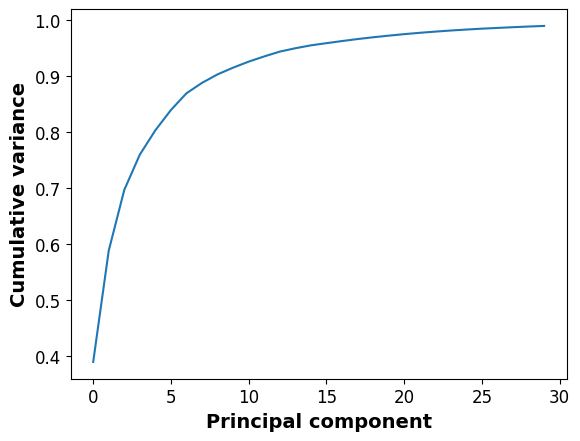

In [ ]:
#@title **Calculating the Variance of Each Principal Component**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

n_pcs = np.where(pca_calc.cumulated_variance > 0.99)[0][0]
atomgroup = u.select_atoms(f'resid {Selection1}:{Selection2}')
pca_space = pca_calc.transform(atomgroup, n_components=n_pcs)

for i in range(10):
    print(f"Cumulated variance for PC{i+1}: {pca_calc.cumulated_variance[i]:.3f}")

transformed = pca_calc.transform(atomgroup, n_components=n_pcs)
transformed.shape
df = pd.DataFrame(transformed,
                  columns=['PC{}'.format(i+1) for i in range(n_pcs)])
df['Frame'] = df.index * u.trajectory.dt

plt.plot(pca_calc.cumulated_variance[:n_pcs])
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Principal component', fontsize = 14, fontweight = 'bold')
plt.ylabel('Cumulative variance', fontsize = 14, fontweight = 'bold')
plt.show()

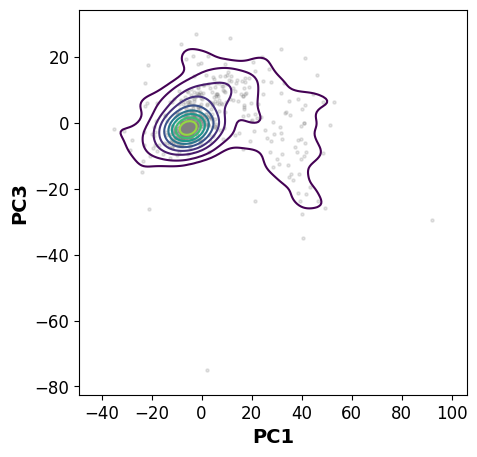

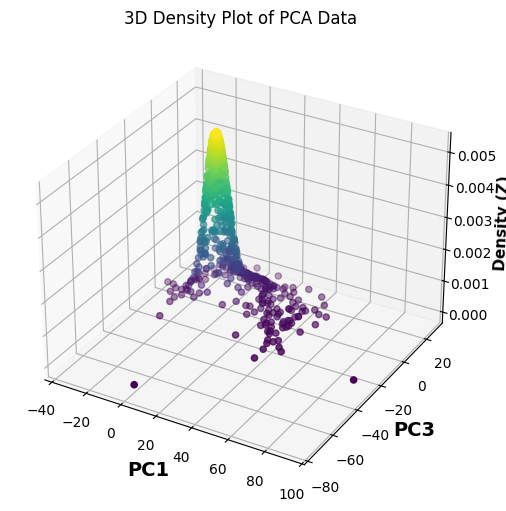

In [ ]:
#@title **Plot the Principle Component Analysis (PCA)**

#@markdown **Provide which principal component you want to plot:**

PC_x = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
PC_y = "3" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

PC1 = df[f'PC{PC_x}'].tolist()
PC2 = df[f'PC{PC_y}'].tolist()

# Create the figure
plt.figure(figsize=(5, 5))
plt.scatter(PC1, PC2, s=5, color="gray", alpha=0.2)

# Plot a KDE contour map (no fill)
sns.kdeplot(x=PC1, y=PC2, cmap="viridis", levels=10, linewidths=1.5)

plt.xlabel(f"PC{PC_x}", fontsize = 14, fontweight = 'bold')
plt.ylabel(f"PC{PC_y}", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig(os.path.join(workDir, f"PC{PC_x}_PC{PC_y}_2D.png"), dpi=600, bbox_inches='tight')

# Compute KDE
xy = np.vstack([PC1, PC2])
kde = gaussian_kde(xy)(xy)  # Evaluates the density at each point

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Scatter plot with Z as density
ax.scatter(PC1, PC2, kde, c=kde, cmap='viridis')

# Labels
ax.set_xlabel(f"PC{PC_x}", fontsize = 14, fontweight = 'bold')
ax.set_ylabel(f"PC{PC_y}", fontsize = 14, fontweight = 'bold')
ax.set_zlabel("Density (Z)", fontsize = 11, fontweight = 'bold')
ax.set_title("3D Density Plot of PCA Data")

# plt.show()
plt.savefig(os.path.join(workDir, f"PC{PC_x}_PC{PC_y}_3D.png"), dpi=600, bbox_inches='tight')
pc1=pd.DataFrame(PC1)
pc1.to_csv(os.path.join(workDir, f"PC{PC_x}.csv"))
pc2=pd.DataFrame(PC2)
pc2.to_csv(os.path.join(workDir, f"PC{PC_y}.csv"))

---
---
# **General Analysis**

Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of ensemble trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations.

Below, you can find a few examples of code snippets that can help you to shed some light on your ensemble behavior.

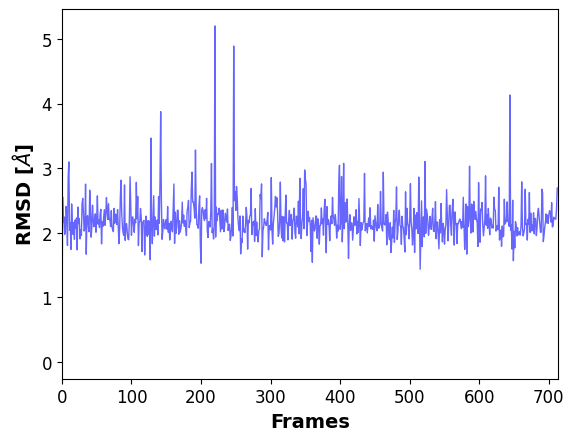

In [ ]:
#@title **Compute RMSD of protein's CA atoms**
#@markdown **Provide output file names below:**
Output_name = 'rmsd_ca' #@param {type:"string"}

import matplotlib.pyplot as plt
import pandas as pd
rmsd = pt.rmsd(traj_load, ref = 0, mask = "@CA")

# Plotting:
ax = plt.plot(rmsd, alpha=0.6, color = 'blue', linewidth = 1.0)
plt.xlim(0, len(rmsd))
#plt.ylim(2, 6)

plt.xlabel("Frames", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

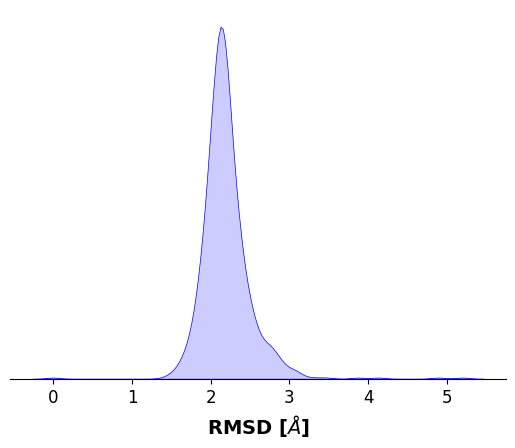

In [ ]:
#@title **Plot RMSD as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'rmsd_dist' #@param {type:"string"}
import seaborn as sb
ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

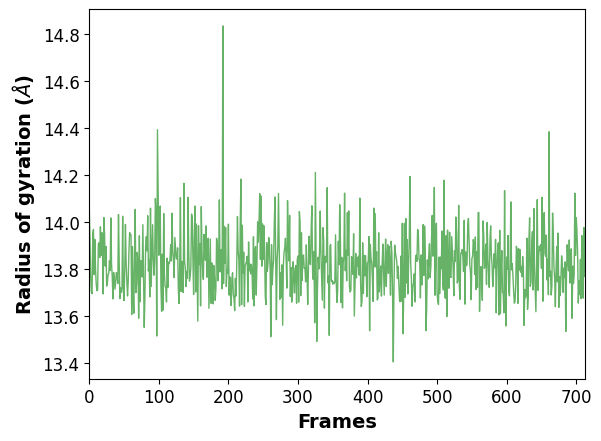

In [ ]:
#@title **Compute radius of gyration of protein's CA atoms**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration' #@param {type:"string"}

radgyr = pt.radgyr(traj_load, mask = "@CA")
# Plotting:
plt.plot(radgyr, alpha=0.6, color = 'green', linewidth = 1.0)
plt.xlim(0, len(radgyr))
#plt.ylim(2, 6)

plt.xlabel("Frames", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(radgyr)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

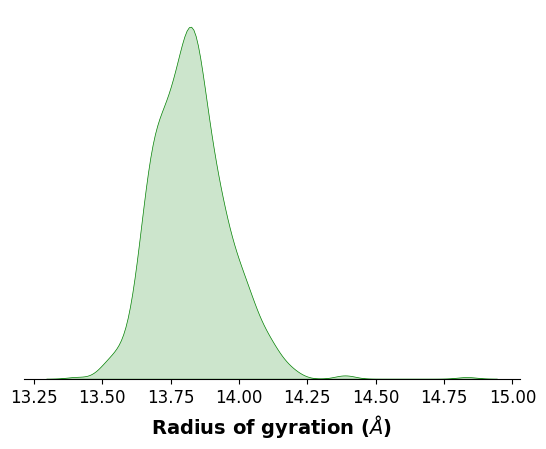

In [ ]:
#@title **Plot radius of gyration as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration_dist' #@param {type:"string"}

ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

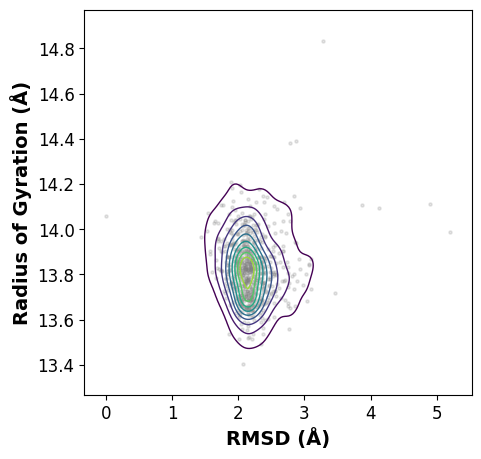

In [ ]:
#@title **Plot RMSD X radius of gyration**

#@markdown **Provide output file names below:**

Output_name = 'rmsd_radius_gyration' #@param {type:"string"}
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Create the figure
plt.figure(figsize=(5, 5))
plt.scatter(rmsd, radgyr, s=5, color="gray", alpha=0.2)

# Plot a KDE contour map (no fill)
sns.kdeplot(x=rmsd, y=radgyr, cmap="viridis", levels=10, linewidths=1)

plt.xlabel(f"RMSD (Å)", fontsize = 14, fontweight = 'bold')
plt.ylabel(f"Radius of Gyration (Å)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

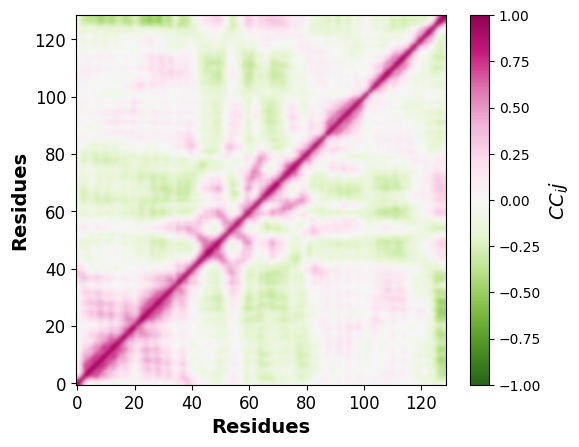

In [ ]:
#@title **Pearson's Cross Correlation (CC)**

#@markdown **Provide output file names below:**
Output_name = 'cross_correlation' #@param {type:"string"}

from pytraj import matrix
traj_align = pt.align(traj_load, mask='@CA', ref=0)

mat_cc = matrix.correl(traj_align, '@CA')

ax = plt.imshow(mat_cc, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')

plt.xlabel('Residues', fontsize = 14, fontweight = 'bold')
plt.ylabel('Residues', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat_cc)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))